In [1]:
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter1d

In [2]:
%matplotlib inline
sns.set_palette('magma')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
BATCH_SIZE = 64
TRAIN_SIZE = 0.8
EPOCHS = 20

In [4]:
train_data = datasets.CIFAR10(root="./cifar10_data", train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.CIFAR10(root="./cifar10_data", train=False, download=True, transform=transforms.ToTensor())

train_size = int(len(train_data) * TRAIN_SIZE)
train_data, val_data = torch.utils.data.random_split(
    train_data, 
    [
        train_size, 
        len(train_data) - train_size
    ]
)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar10_data/cifar-10-python.tar.gz to ./cifar10_data
Files already downloaded and verified


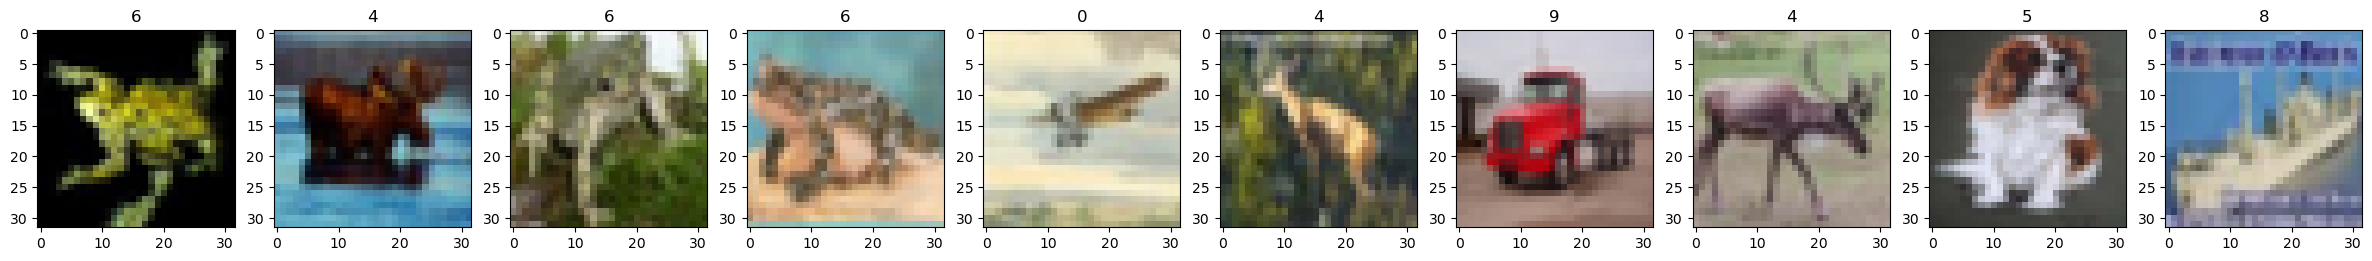

In [5]:
#show 10 random images from train dataset
def show_images(images, labels):
    fig, axes = plt.subplots(1, 10, figsize=(30,5))
    
    for i, axis in enumerate(axes):
        # converting image from tensor to a numpy array
        img = images[i].numpy()
        # converting the image into dimensions (length, width, color channels)
        img = np.transpose(img, (1, 2, 0))

        axes[i].imshow(img)
        axes[i].set_title(labels[i].numpy())

    plt.show()

for batch in train_loader:
    images, labels = batch
    break

show_images(images, labels)

In [6]:
images.shape

torch.Size([64, 3, 32, 32])

In [7]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        
        # 32x32x3->16x16x32
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # 16x16x32->8x8x128
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # 8x8x128->4x4x512
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 512, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.drop_out = nn.Dropout()
        self.fc = nn.Linear(4 * 4 * 512, num_classes)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.drop_out(out)
        out = self.layer2(out)
        out = self.drop_out(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc(out)
        return out

In [8]:
def evaluate(model, dataloader, loss_fn):
    model.eval()
    y_pred_list = []
    y_true_list = []
    loss_list = []
    
    for i, (images, labels) in enumerate(dataloader):
        with torch.no_grad():
            outputs = model(images.to(device))
            loss = loss_fn(outputs, labels.to(device))
            loss_list.append(loss.item())
            
            y_pred = torch.argmax(outputs, dim=1)
            
        y_pred_list.extend(y_pred.cpu().numpy())
        y_true_list.extend(labels.numpy())
        
    accuracy = accuracy_score(y_pred_list, y_true_list)
        
    model.train()
    return accuracy, np.mean(loss_list)

In [9]:
model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_step = len(train_loader)
control_step = total_step // 10

loss_list_train = []
loss_list_val = []
acc_list_train = []
acc_list_val = []

In [10]:
for epoch in range(EPOCHS):
    for i, (images, labels) in enumerate(train_loader):
        #forward
        outputs = model(images.to(device))
        loss = criterion(outputs, labels.to(device))
        
        #backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #loss and accuracy track on train
        preds = torch.argmax(outputs, dim=1)
        acc_train = accuracy_score(preds.cpu(), labels.cpu())
        
        loss_list_train.append(loss.item())
        acc_list_train.append(acc_train)
        
        if (i + 1) % control_step == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Acc: {:.2f}%'
                  .format(epoch + 1, EPOCHS, i + 1, total_step, loss_list_train[-1], acc_list_train[-1] * 100))
            
    #loss and accuracy track on validation
    acc_val, loss_val = evaluate(model, val_loader, criterion)
    loss_list_val.append(loss_val)
    acc_list_val.append(acc_val)
    
    print('Epoch [{}/{}] completed, validation loss: {:.4f}, validation acc: {:.2f}%'
         .format(epoch + 1, EPOCHS, loss_val, acc_val * 100), end='\n\n')

Epoch [1/20], Step [62/625], Loss: 1.9648, Acc: 31.25%
Epoch [1/20], Step [124/625], Loss: 1.9278, Acc: 28.12%
Epoch [1/20], Step [186/625], Loss: 1.6612, Acc: 42.19%
Epoch [1/20], Step [248/625], Loss: 1.6202, Acc: 43.75%
Epoch [1/20], Step [310/625], Loss: 1.7666, Acc: 42.19%
Epoch [1/20], Step [372/625], Loss: 1.4777, Acc: 50.00%
Epoch [1/20], Step [434/625], Loss: 1.3130, Acc: 57.81%
Epoch [1/20], Step [496/625], Loss: 1.5686, Acc: 42.19%
Epoch [1/20], Step [558/625], Loss: 1.5138, Acc: 45.31%
Epoch [1/20], Step [620/625], Loss: 1.4463, Acc: 48.44%
Epoch [1/20] completed, validation loss: 1.5904, validation acc: 45.42%

Epoch [2/20], Step [62/625], Loss: 1.1186, Acc: 59.38%
Epoch [2/20], Step [124/625], Loss: 1.2983, Acc: 53.12%
Epoch [2/20], Step [186/625], Loss: 1.2508, Acc: 54.69%
Epoch [2/20], Step [248/625], Loss: 1.1505, Acc: 60.94%
Epoch [2/20], Step [310/625], Loss: 1.0606, Acc: 57.81%
Epoch [2/20], Step [372/625], Loss: 1.1804, Acc: 56.25%
Epoch [2/20], Step [434/625], Los

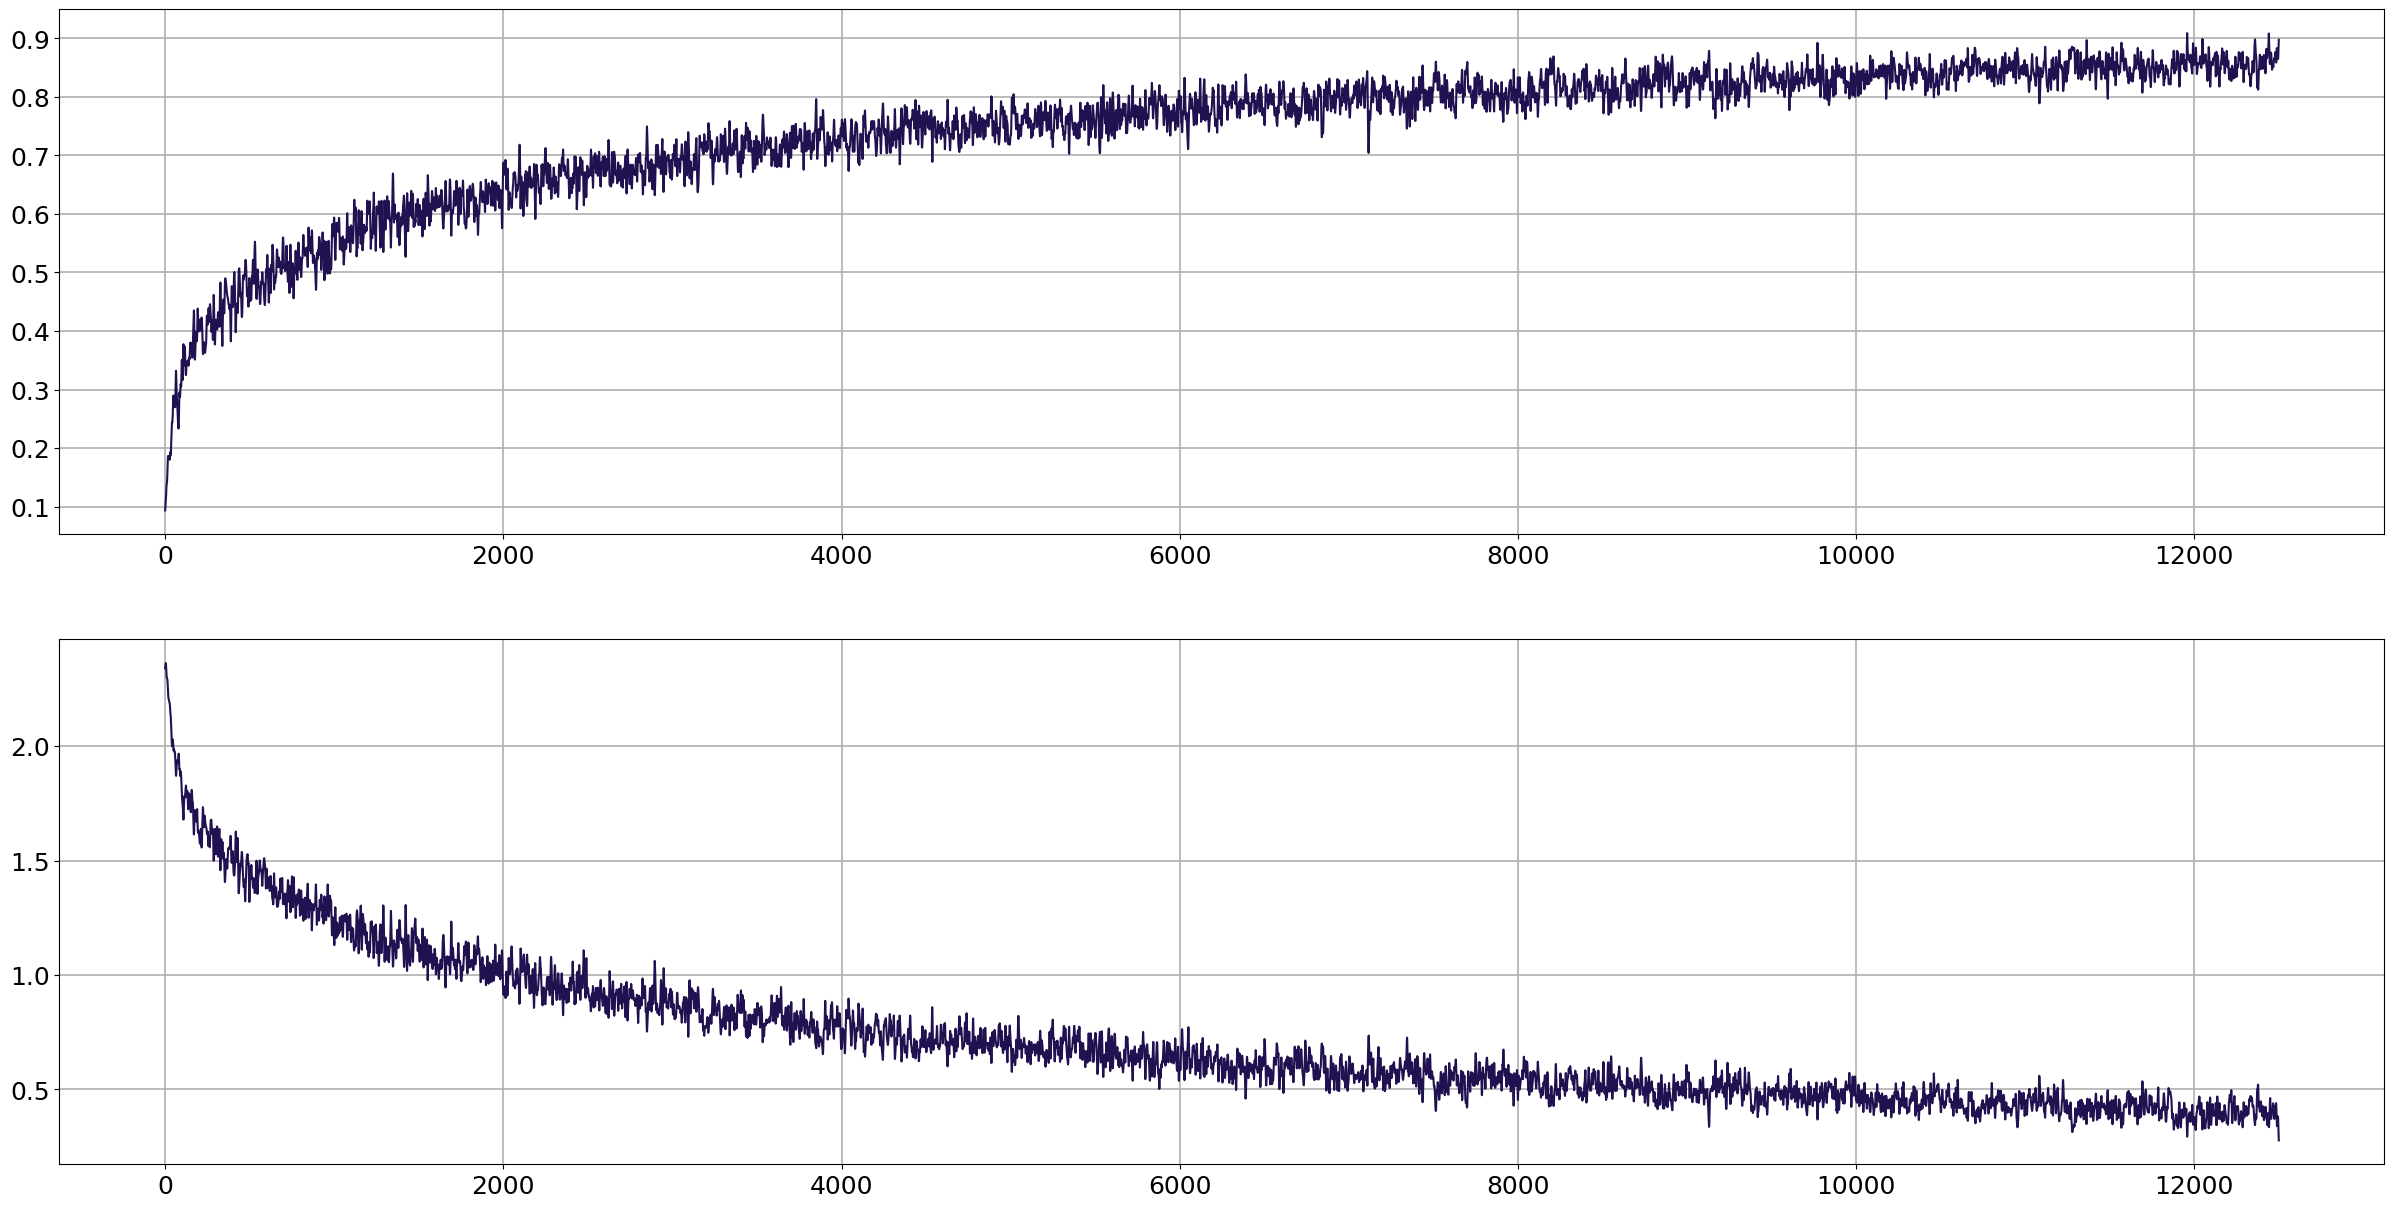

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(30, 15))

axes[0].plot(gaussian_filter1d(acc_list_train, sigma=2))
axes[0].tick_params(axis='both', which='major', labelsize=18, grid_linewidth=1.2)
axes[0].grid()

axes[1].plot(gaussian_filter1d(loss_list_train, sigma=2))
axes[1].tick_params(axis='both', which='major', labelsize=18, grid_linewidth=1.2)
axes[1].grid()

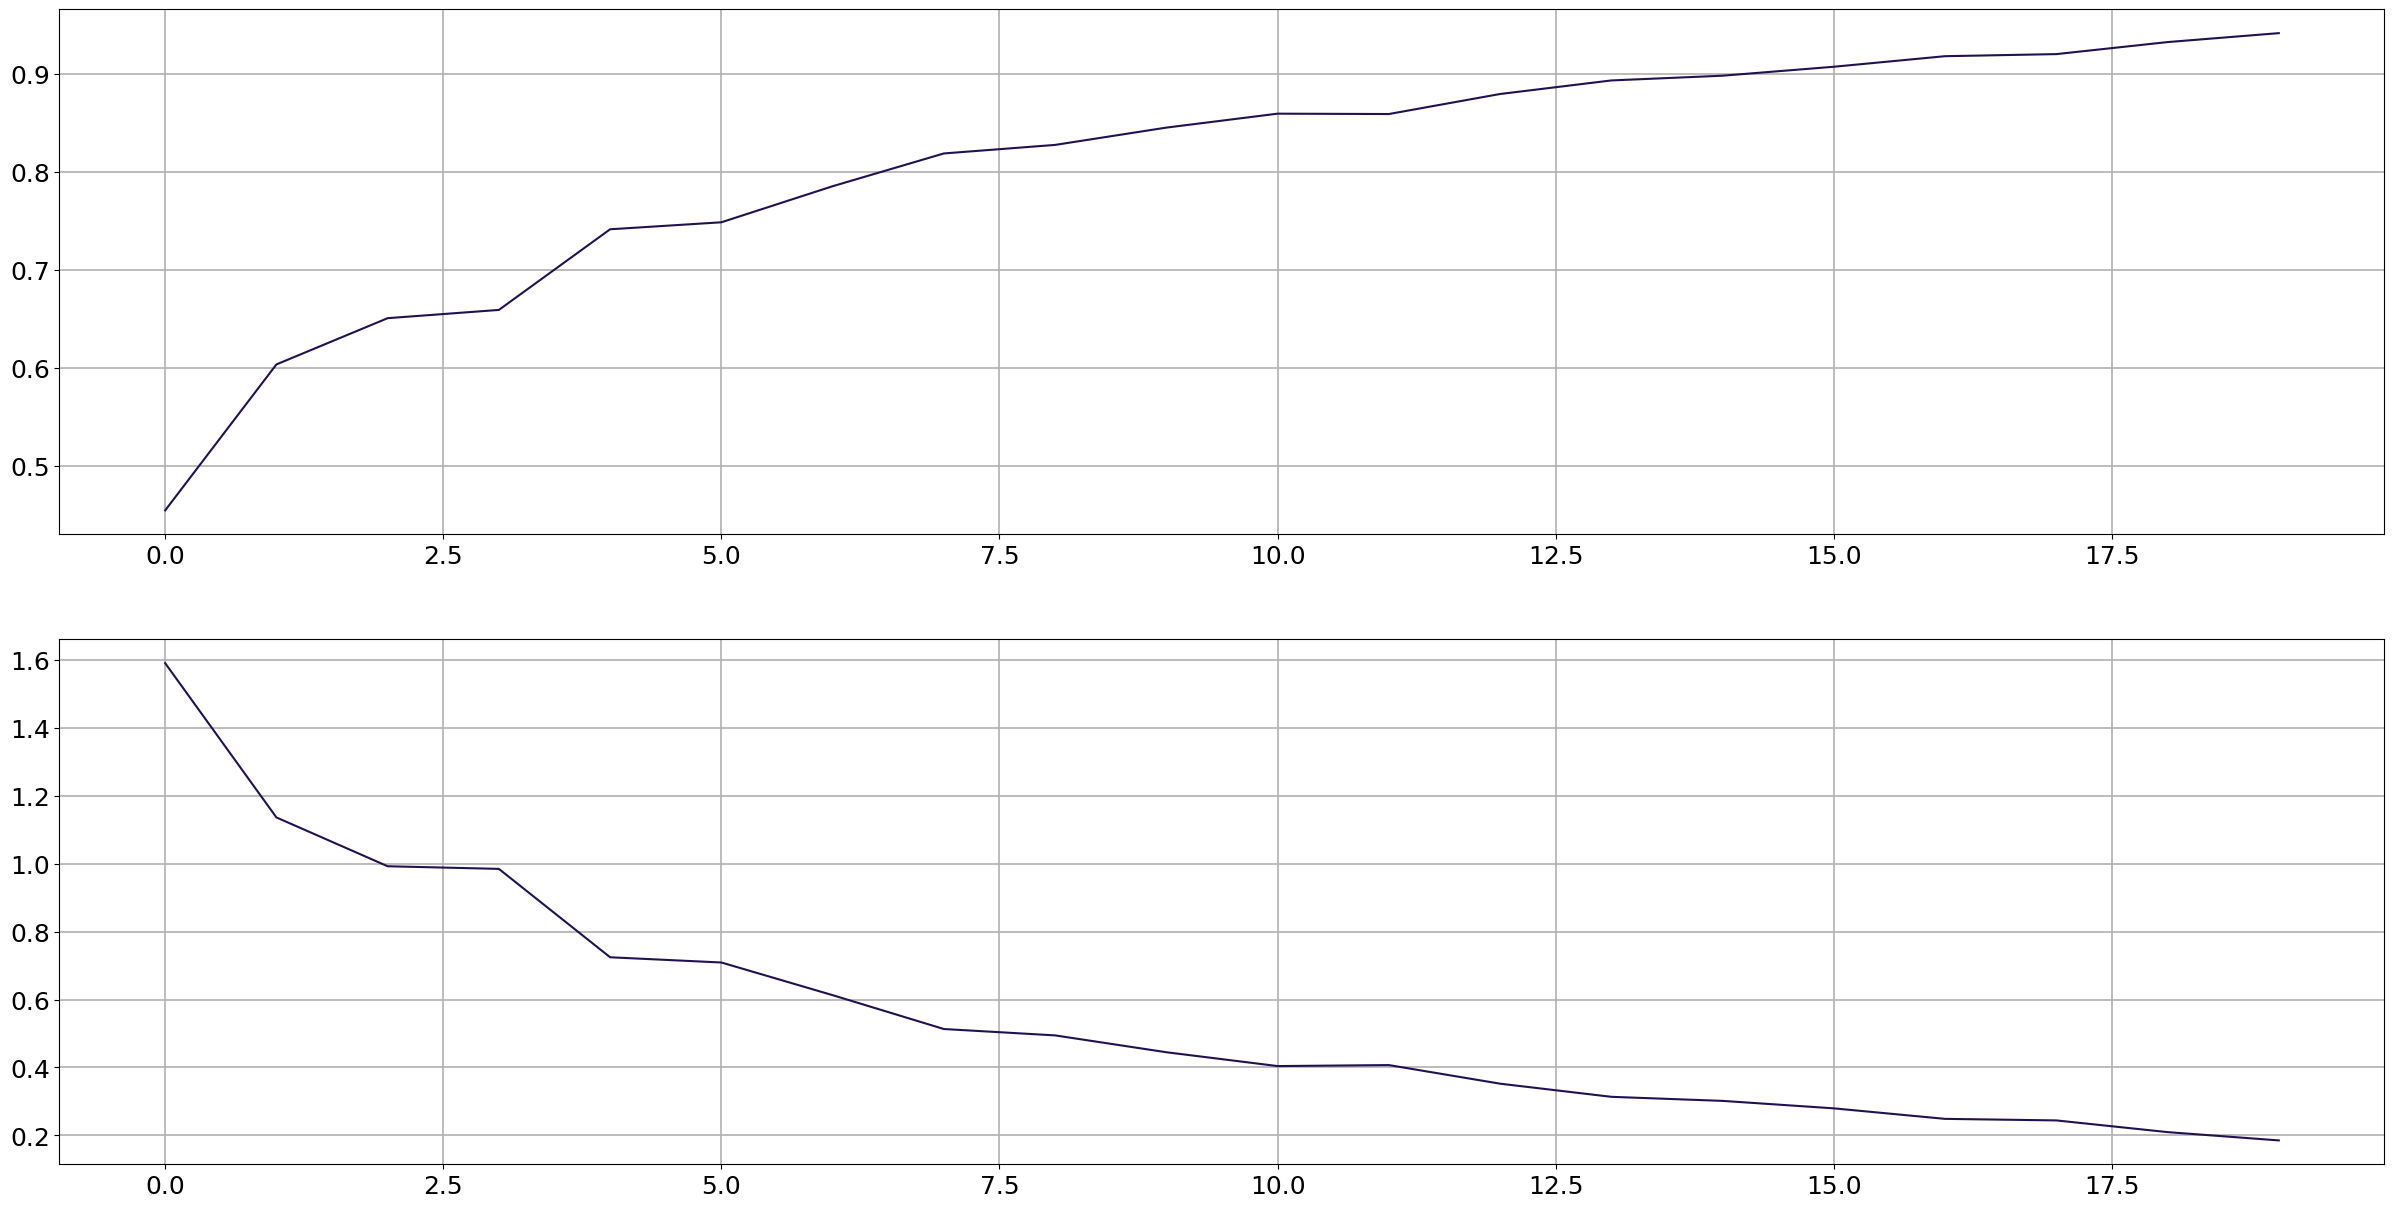

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(30, 15))

axes[0].plot(acc_list_val)
axes[0].tick_params(axis='both', which='major', labelsize=18, grid_linewidth=1.2)
axes[0].grid()

axes[1].plot(loss_list_val)
axes[1].tick_params(axis='both', which='major', labelsize=18, grid_linewidth=1.2)
axes[1].grid()

In [13]:
acc_test, _ = evaluate(model, test_loader, criterion)
print('Test Accuracy of the model on the {} test images: {:.02f} %'.format(len(test_loader), acc_test * 100))

Test Accuracy of the model on the 157 test images: 82.78 %
